In [2]:
from keras.models import Model
from keras.layers import Conv2D, Activation, Input, Add, Dense, Flatten, Dropout, MaxPooling2D 


In [3]:
train_dir = r'C:\Users\dani\Documents\face-emotion-detection\FER-13\train'
test_dir = r'C:\Users\dani\Documents\face-emotion-detection\FER-13\test'

In [41]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the training data generator with additional augmentations
train_datagen = ImageDataGenerator(
    shear_range=0.3,             # Randomly shear images
    zoom_range=0.3,              # Randomly zoom into images
    rotation_range=30,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    brightness_range=[0.8, 1.2], # Randomly adjust brightness
    rescale=1./255,              # Rescale pixel values to [0, 1]
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest',         # Fill missing pixels after transformations
    validation_split=0.2         # Set aside 20% of the data for validation
)

# Define the validation data generator (simpler augmentations)
validation_datagen = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values to [0, 1]
    validation_split=0.2         # Set aside 20% of the data for validation
)

In [44]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,         # Directory containing the training data
    target_size=(55, 47),        # Resize all images to 55x47 pixels
    batch_size=32,               # Number of images per batch
    color_mode="rgb",            # Convert images to RGB
    class_mode="categorical",    # Multi-class classification
    subset="training",           # Use the training subset
    shuffle=True                 # Shuffle the data
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,          # Directory containing the validation data
    target_size=(55, 47),        # Resize all images to 55x47 pixels
    batch_size=32,               # Number of images per batch
    color_mode="rgb",            # Convert images to RGB
    class_mode="categorical",    # Multi-class classification
    subset="validation",         # Use the validation subset
    shuffle=True                 # Shuffle the data
)


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [46]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar yang diaugmentasi
def display_augmented_images(generator, class_labels, num_images=9):
    """
    Menampilkan gambar augmentasi dengan label kelas.
    
    Args:
    - generator: Generator data yang mengembalikan gambar dan label.
    - class_labels: List nama kelas sesuai urutan label dari generator.
    - num_images: Jumlah gambar yang ingin ditampilkan.
    """
    # Ambil satu batch gambar dari generator
    data_iter = next(generator)
    images, labels = data_iter  # Gambar dan label
    
    # Tampilkan beberapa gambar yang diaugmentasi
    plt.figure(figsize=(10, 10))
    plt.suptitle("Gambar Augmentasi", fontsize=16)
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Membuat grid 3x3
        plt.imshow(images[i])
        class_index = labels[i].argmax()  # Cari indeks kelas
        plt.title(class_labels[class_index], fontsize=10)  # Tambahkan nama kelas
        plt.axis('on')  # Nonaktifkan sumbu
    plt.tight_layout()
    plt.show()

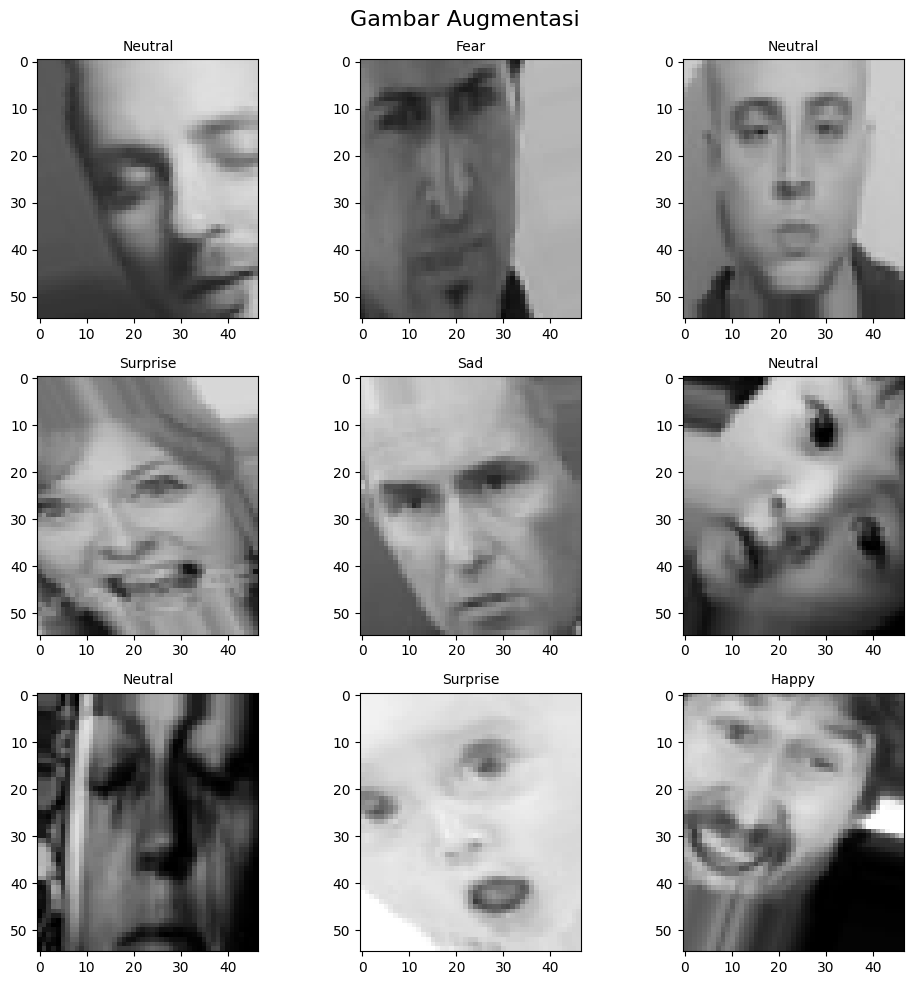

In [47]:
# Tampilkan gambar yang diaugmentasi
display_augmented_images(train_generator, class_labels, num_images=9)

In [48]:
# Definisikan arsitektur model
myInput = Input(shape=(55, 47, 3))

x = Conv2D(20, (4, 4), name='Conv1', activation='relu')(myInput)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool1')(x)
x = Dropout(rate=0.5, name='D1')(x)  # Dropout rate disesuaikan

x = Conv2D(40, (3, 3), name='Conv2', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool2')(x)
x = Dropout(rate=0.5, name='D2')(x)

x = Conv2D(60, (3, 3), name='Conv3', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool3')(x)
x = Dropout(rate=0.5, name='D3')(x)

x1 = Flatten()(x)
fc11 = Dense(160, name='fc11')(x1)

x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(x)
x2 = Flatten()(x2)
fc12 = Dense(160, name='fc12')(x2)

y = Add()([fc11, fc12])
y = Activation('relu', name='deepid')(y)

# Menambahkan layer output untuk klasifikasi emosi
output = Dense(7, activation='softmax', name='emotion_output')(y)

model = Model(inputs=[myInput], outputs=output)


In [49]:
# Memuat bobot pre-trained DeepID
weights_path = 'deepid_keras_weights.h5'  # Ganti dengan path ke file weights Anda
model.load_weights(weights_path, by_name=True)

In [50]:
# Mencetak arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 55, 47, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 52, 44,    │        980 │ input_layer[0][0] │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool1               │ (None, 26, 22,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D1 (Dropout)        │ (None, 26, 22,    │          0 │ Pool1[0][0]       │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 24, 20,    │      7,240 │ D1[0][0]          │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool2               │ (None, 12, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D2 (Dropout)        │ (None, 12, 10,    │          0 │ Pool2[0][0]       │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv2D)      │ (None, 10, 8, 60) │     21,660 │ D2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool3               │ (None, 5, 4, 60)  │          0 │ Conv3[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D3 (Dropout)        │ (None, 5, 4, 60)  │          0 │ Pool3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv4 (Conv2D)      │ (None, 4, 3, 80)  │     19,280 │ D3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1200)      │          0 │ D3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 960)       │          0 │ Conv4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc11 (Dense)        │ (None, 160)       │    192,160 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc12 (Dense)        │ (None, 160)       │    153,760 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160)       │          0 │ fc11[0][0],       │
│                     │                   │            │ fc12[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deepid (Activation) │ (None, 160)       │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 7)         │      1,127 │ deepid[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 396,207 (1.51 MB)

 Trainable params: 396,207 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [56]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback untuk menyimpan model terbaik dan early stopping
checkpoint = ModelCheckpoint(
    'best_model_fer2013.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    verbose=1
)

In [57]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

c:\Users\dani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


c:\Users\dani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2044 - loss: 5.6015
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to best_model_fer2013.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 100ms/step - accuracy: 0.2044 - loss: 5.5973 - val_accuracy: 0.2472 - val_loss: 1.8185
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2503 - loss: 1.8142
Epoch 2: val_accuracy did not improve from 0.24721
718/718 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2503 - loss: 1.8142 - val_accuracy: 0.2472 - val_loss: 1.8139
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2493 - loss: 1.8135
Epoch 3: val_accuracy did not improve from 0.24721
718/718 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.2493 - loss: 1.8135 - val_accuracy: 0.2472 - val_loss: 1.8134
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2521 - loss: 1.8101
Epoch 4: val_accuracy did not improve from 0.24721
718/718 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - accuracy: 

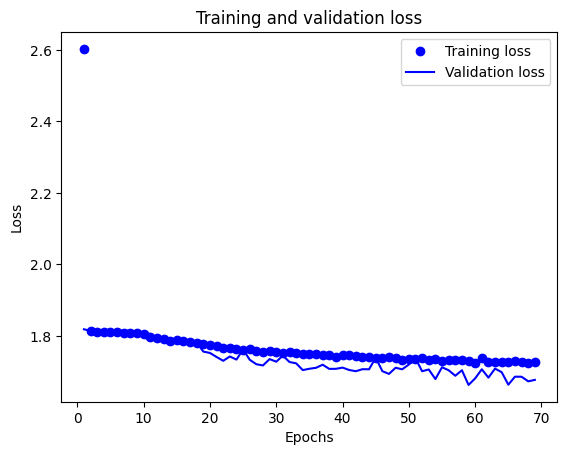

In [58]:

# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

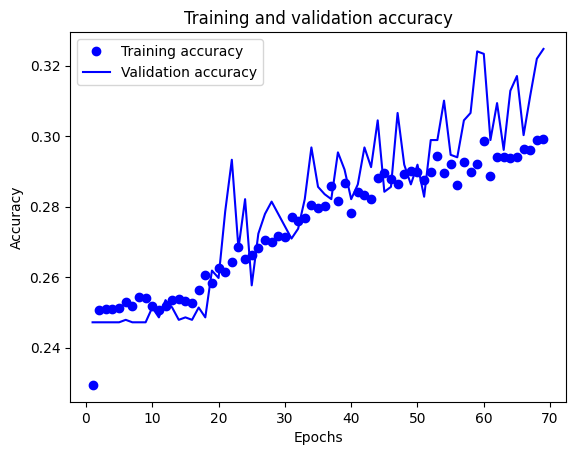

In [59]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Mengambil label dari generator validasi
val_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  # Nama kelas

# Memprediksi data validasi
val_predictions = model.predict(validation_generator, verbose=1)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_pred_classes, target_names=class_labels, zero_division=0))


 7/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

c:\Users\dani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       191
     disgust       0.00      0.00      0.00        22
        fear       0.16      0.02      0.04       204
       happy       0.25      0.60      0.35       354
     neutral       0.16      0.23      0.19       246
         sad       0.15      0.02      0.04       249
    surprise       0.11      0.12      0.12       166

    accuracy                           0.21      1432
   macro avg       0.12      0.14      0.11      1432
weighted avg       0.15      0.21      0.15      1432



45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


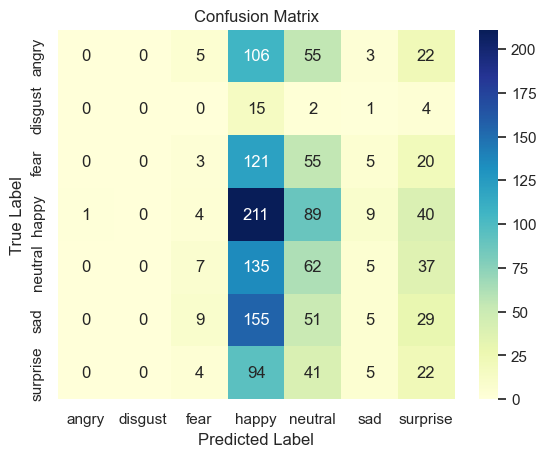

In [61]:
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Evaluate the Model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3243 - loss: 1.6829
Validation Accuracy: 32.47%
Validation Loss: 167.69%


c:\Users\dani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


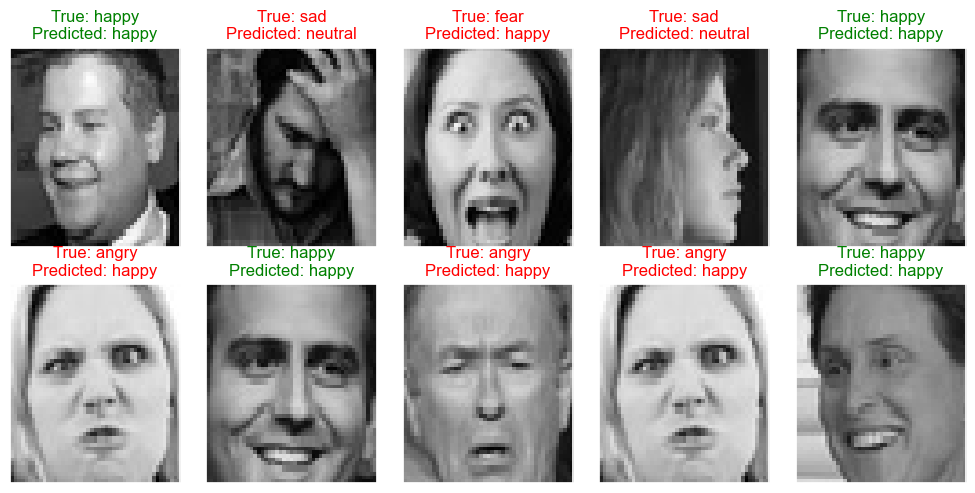

In [63]:
import tensorflow as tf

# Assuming test_generator and model are already defined
batch_size = validation_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(validation_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = validation_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(validation_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if class_labels[Random_Img_Label] == class_labels[Model_Prediction] else "red"
    ax.set_title(f"True: {class_labels[Random_Img_Label]}\nPredicted: {class_labels[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

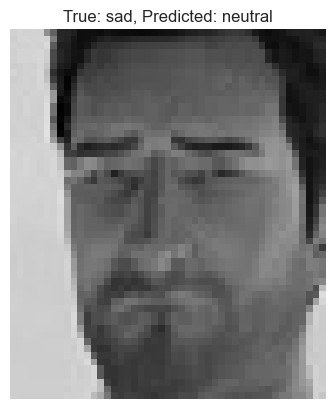

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

# Fungsi untuk memprediksi gambar tunggal
def predict_single_image(generator, model, image_index):
    """
    Memilih satu gambar dari generator, memprediksi labelnya, dan menampilkan gambar dengan label asli dan prediksi.
    
    Parameters:
        generator (DirectoryIterator): Generator data (contoh: validation_generator).
        model (Model): Model yang telah dilatih.
        image_index (int): Indeks gambar di generator untuk dipilih.
    
    Returns:
        None
    """
    # Ambil gambar dan label asli dari generator
    batch_size = generator.batch_size
    batch_index = image_index // batch_size
    within_batch_index = image_index % batch_size
    
    # Dapatkan batch gambar dan label dari generator
    generator.reset()
    for i in range(batch_index + 1):
        images, labels = next(generator)
    
    # Ambil gambar dan label pada indeks tertentu
    image = images[within_batch_index]
    true_label = np.argmax(labels[within_batch_index])
    
    # Prediksi label menggunakan model
    prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
    predicted_label = np.argmax(prediction)

    # Nama kelas
    class_labels = list(generator.class_indices.keys())
    true_label_name = class_labels[true_label]
    predicted_label_name = class_labels[predicted_label]
    
    # Tampilkan gambar dengan label
    plt.imshow(image.squeeze())  # Jika grayscale, gunakan .squeeze()
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.axis("off")
    plt.show()

# Contoh penggunaan
predict_single_image(validation_generator, model, image_index=10)
